In [232]:
%run SetUp.ipynb

In [233]:
#angles_from_vqe = np.array([-0.56718282,  0.44043292, -0.19426729])
#angles_from_vqe = np.array([-0.3188006])

angles_from_vqe =[ 0.44285798, -0.15949663, -0.04035574]

## Define VQE form (Old and slow but works) (Using form for vacuum prep for now)

In [234]:
# Layers of VQE

# def PYP(angle,nq):
#     n_sets = int(nq/3)
#     mat = sp.sparse.identity(2**nq)
#     angle = angle/2

#     for mmm in range(n_sets):
#         cc,dd,ee = (3*mmm+2)%nq,(3*mmm+3)%nq,(3*mmm+4)%nq
#         mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(cc,nq,proj0) @ pad_op(dd,nq,y) @ pad_op(ee,nq,proj0))
#         mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(cc,nq,proj1) @ pad_op(dd,nq,y) @ pad_op(ee,nq,proj1))

#     for mm in range(n_sets):
#         bb,cc,dd = (3*mm+1)%nq,(3*mm+2)%nq,(3*mm+3)%nq
#         mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0))
#         mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1))

        
#     for m in range(n_sets):
#         aa,bb,cc = (3*m)%nq,(3*m+1)%nq,(3*m+2)%nq
#         mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0))
#         mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1))
    

#     return mat


In [235]:
# def vqe_form(angles,nq):
#     it = iter(angles)
#     mat = sp.sparse.identity(2**nq)
#     for i in range(len(angles)):
#         angle = next(it)
#         mat @= PYP(angle,nq)
#     return mat

## Define VQE form

In [236]:
# Layers of VQE
# "which is either proj0 or proj1"

def PYP(angle,nq,which,state):
    n_sets = int(nq/2)
    mat1 = sp.sparse.identity(2**nq)
    mat2 = sp.sparse.identity(2**nq)

    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle * pad_op(bb,nq,which) @ pad_op(cc,nq,y) @ pad_op(dd,nq,which),state) #-1j * 
        
    #state = mat1 @ state
    
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle * pad_op(aa,nq,which) @ pad_op(bb,nq,y) @ pad_op(cc,nq,which),state)
        
    #state = sp.sparse.linalg.expm_multiply(-1j * mat2, state)

    return state


In [237]:
def apply_vqe_form(angles,nq,state):
    it = iter(angles)
    #mat = sp.sparse.identity(2**nq)
    for i in range(len(angles)):
        if i % 2 == 0: # ugh
            proj = proj1
        else: proj = proj0
        angle = next(it)
        state = PYP(angle,nq,proj,state)
    return state

# Classical Calculation 12 qubits

In [238]:
nQQ = 12

In [239]:

# Generate Fake Vacuum
def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray()).transpose()


In [240]:

# Turn on 3 links in the middle
def activate(init,nq): # init is a function of nq, init(nq) is a state
    if nq <= 5: raise Exception (" Size of system too small. Operate on number of qubits >= 6")
    loc = (nq-5) // 2
    P0XXXP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,x,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),P0XXXP0,sp.sparse.identity(2**(nq-loc-5))]) 
    return sp.sparse.linalg.expm_multiply(-1j * act_mat,init(nq))
    
# Unitary evolution on any initial with angles found in VQE1 to establish true vaccum
# this is currently very slow.

def true_vac(state,nq):
    return apply_vqe_form(angles_from_vqe,nq,state)

In [241]:

# Initialize State
vacuum = true_vac(fake_vac(nQQ),nQQ)
initial = true_vac(activate(fake_vac,nQQ),nQQ)

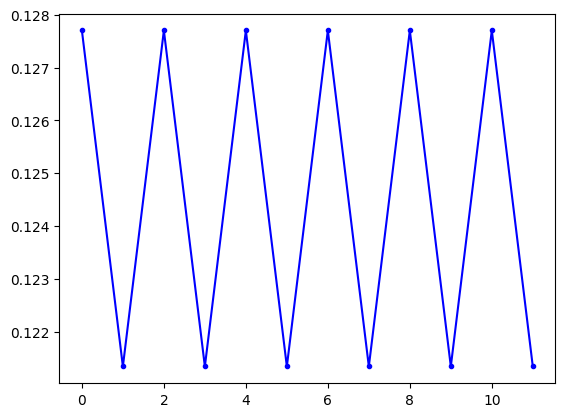

In [242]:
plot_E_per_site(vacuum,nQQ)

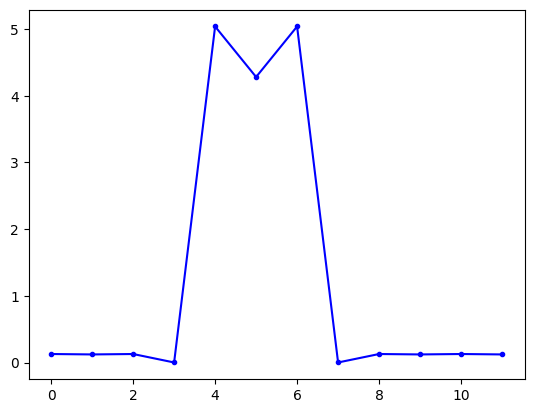

In [243]:
plot_E_per_site(initial,nQQ)

In [244]:
sp.sparse.linalg.norm(initial)

1.0000000000000002

In [245]:
Hf = sp.sparse.csr_matrix(np.real(Hfull(nQQ,m,g).to_matrix()))

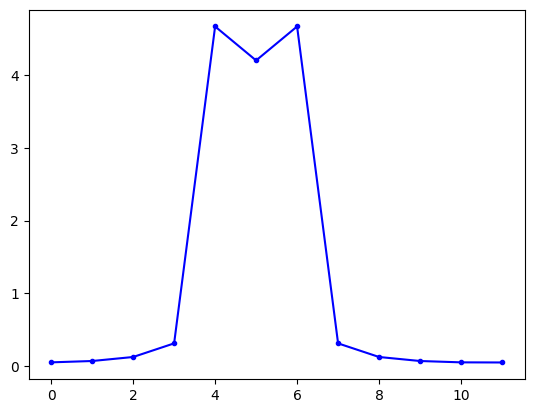

In [246]:
# Time evolution. Evolve with e^(-iHt)
final_state = sp.sparse.linalg.expm_multiply(-1j * Hf * 8, initial)
plot_E_per_site(final_state,nQQ)

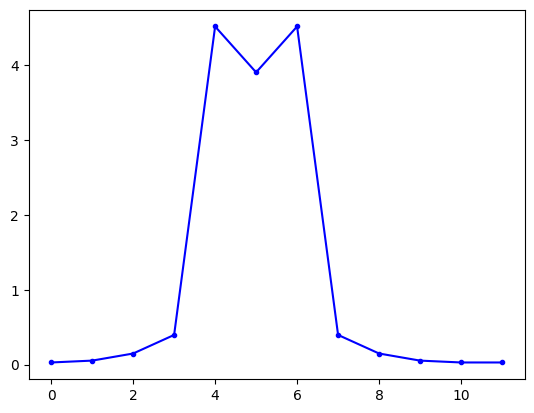

In [247]:
final_state_2 = sp.sparse.linalg.expm_multiply(-1j * Hf * 10,initial)

plot_E_per_site(final_state_2,nQQ)

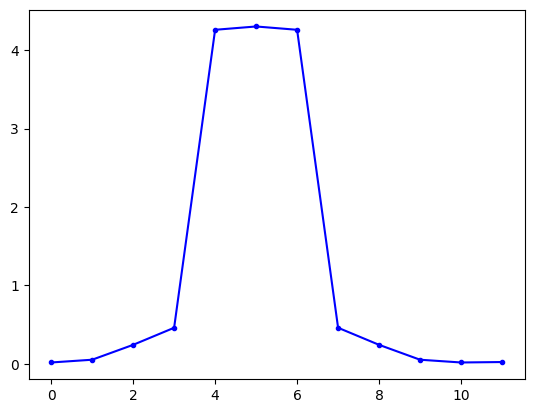

In [248]:
# Time evolution. Evolve with e^(-iHt)

final_state_3 = sp.sparse.linalg.expm_multiply(-1j * Hf * 14,initial)

plot_E_per_site(final_state_3,nQQ)

In [251]:
ts = np.arange(0, 10, 1) # iffy on where to start and where to stop
sites = np.arange(0, nQQ, 1) # iffy on where to start and where to stop

Data = []
for i in ts:
    final_state = sp.sparse.linalg.expm_multiply(-1j * Hf * i,initial)
    E_exps = []
    for loc in sites:
        E_exps += [(np.real(final_state.getH() @ He_persite_scipy(nQQ,g,loc) @ final_state)).toarray()[0][0]] # Should be CT(state).H.state
    Data.append(E_exps)


/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5974/1834702825.py:9: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  E_exps += [(np.real(final_state.getH() @ He_persite_scipy(nQQ,g,loc) @ final_state)).toarray()[0][0]] # Should be CT(state).H.state


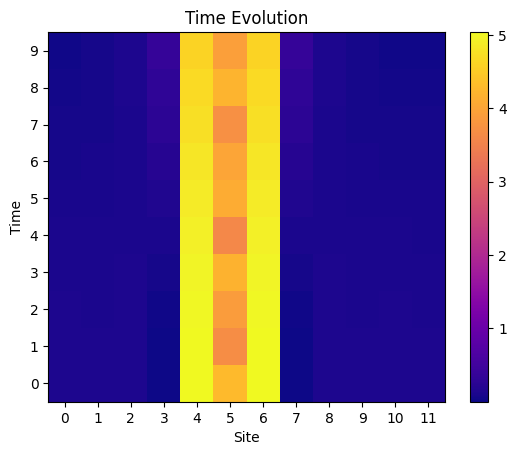

In [252]:
plt.pcolormesh(sites, ts, Data)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ts)
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Time Evolution")
plt.show()

# Classical Calculation 16 qubits

In [23]:
nQ = 16

In [24]:
# Initialize State
vacuum16 = true_vac(fake_vac(nQ),nQ)
initial16 = true_vac(activate(fake_vac,nQ),nQ)

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5635/1465850907.py:4: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  E_exps += [(np.real(state.getH() @ He_persite_scipy(nq,g,loc) @ state)).toarray()[0][0]] # Should be CT(state).H.state


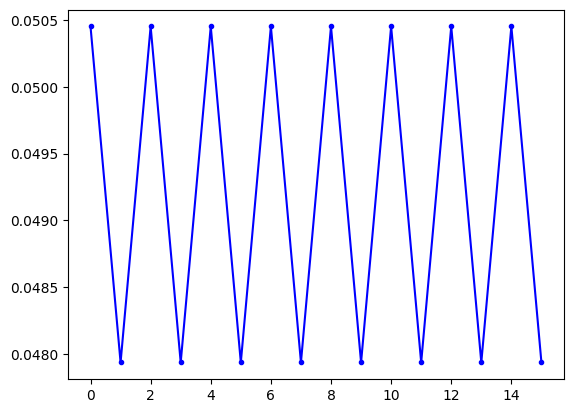

In [25]:
plot_E_per_site(vacuum16,nQ)

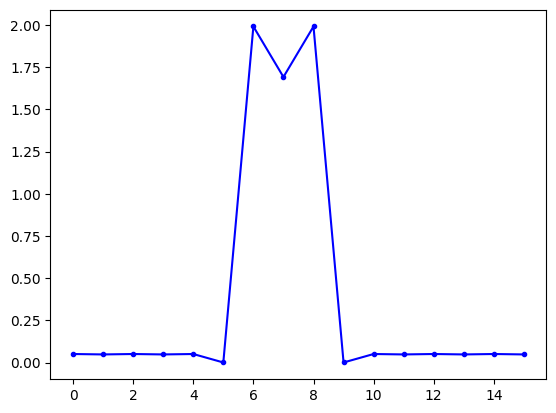

In [26]:
plot_E_per_site(initial16,nQ)

In [27]:
sp.sparse.linalg.norm(initial16)

0.9999999999999992

In [28]:
Hf16 = sp.sparse.csr_matrix(np.real(Hfull(nQ,m,g).to_matrix()))

In [ ]:
ts16 = np.arange(0, 20, 1) # iffy on where to start and where to stop
sites16 = np.arange(0, nQ, 1) # iffy on where to start and where to stop

Data16 = []
for i in ts16:
    final_state16 = sp.sparse.linalg.expm_multiply(-1j * Hf16 * i,initial16)
    E_exps16 = []
    for loc in sites16:
        E_exps16 += [(np.real(final_state16.getH() @ He_persite_scipy(nQ,g,loc) @ final_state16)).toarray()[0][0]] # Should be CT(state).H.state
    Data16.append(E_exps16)


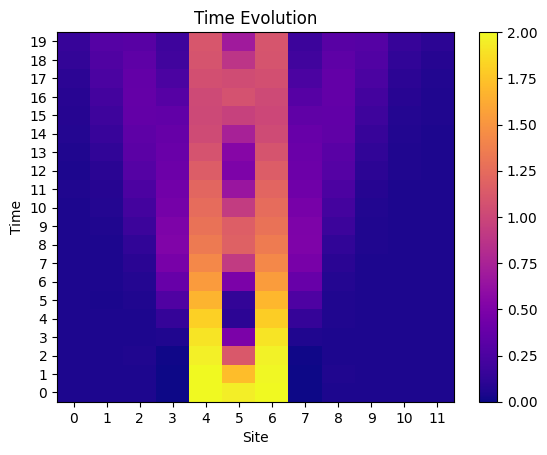

In [ ]:
plt.pcolormesh(sites16, ts16, Data16)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ts)
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Time Evolution")
plt.show()

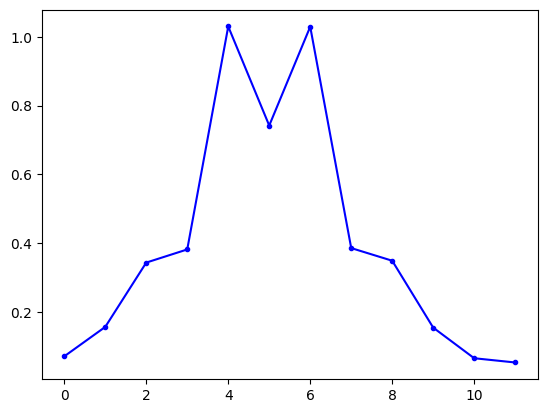

In [ ]:
# Time evolution. Evolve with e^(-iHt)

final_state_3 = sp.sparse.linalg.expm_multiply(-1j * Hf * 14,initial)

plot_E_per_site(final_state_3,nQQ)

# Move to QC

In [ ]:
nQ = 100

In [ ]:
# VQE2 to learn how to prepare the state generated above on the smaller number of qubits

In [ ]:
# Use VQE1 results to prepare the 100 qubit QC to vacuum state

full_cir = one_layer(nQ, angles_from_vqe)

testcir = Statevector.from_int(0, 2**nQ)
testcir = testcir.evolve(test)
#results = testcir.probabilities_dict()
results = np.real(testcir.data)

plt.plot(list(range(2**nQ)), results,'b.',label = 'VQE 1 layer')

In [ ]:
# Put the smaller evolved state on to QC

In [ ]:
# Time evolution to the extend of QC available depth
# e^iHt needs to be redefined in gates form and Trotterized 